In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Teleworkability
wfh_share_estimation = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/results/wfh_estimates.csv")
bls = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/processed/bls/oews/oews_all_2023.csv", low_memory=False)
bls['TOT_EMP'] = pd.to_numeric(bls['TOT_EMP'], errors='coerce')
bls_ind_3d = bls.loc[
    (bls.I_GROUP == "3-digit") &
    (bls.O_GROUP == 'detailed')
].copy()
bls_ind_3d["NAICS"] = bls_ind_3d["NAICS"].astype(str).apply(lambda x: x[:3])
bls_ind_4d = bls.loc[
    (bls.I_GROUP == "4-digit") &
    (bls.O_GROUP == 'detailed')
].copy()
bls_ind_4d["NAICS"] = bls_ind_4d["NAICS"].astype(str).apply(lambda x: x[:4])

productivity_4d = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/processed/bls/productivity/productivity_4_Digit.csv", dtype={'NAICS': str})
productivity_3d = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/processed/bls/productivity/productivity_3_Digit.csv", dtype={'NAICS': str})

prod_coverage_4d = bls_ind_4d[bls_ind_4d.NAICS.isin(productivity_4d.NAICS)].TOT_EMP.sum() / bls_ind_4d.TOT_EMP.sum()
prod_coverage_3d = bls_ind_3d[bls_ind_3d.NAICS.isin(productivity_3d.NAICS)].TOT_EMP.sum() / bls_ind_3d.TOT_EMP.sum()
print(f"Productivity coverage for 4-digit NAICS: {prod_coverage_4d:2%} of total employment.")
print(f"Productivity coverage for 3-digit NAICS: {prod_coverage_3d:2%} of total employment.")

# WFH rates by industry (from ACS)
wfh_rates = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/processed/acs/acs_136_YEAR_INDNAICS.csv")
# Exclude :
    # Agriculture, Forestry, Fishing and Hunting: Codes starting with "11"
    # Public Administration & Military : Codes starting with "92"
    # Unemployed: Codes starting with "99"
wfh_rates = wfh_rates.loc[
    (~wfh_rates.INDNAICS.str.startswith("11")) &
    (~wfh_rates.INDNAICS.str.startswith("92")) &
    (~wfh_rates.INDNAICS.str.startswith("99"))
].copy()
wfh_rates["NAICS"] = wfh_rates["INDNAICS"].astype(str).apply(lambda x: x[:3])
wfh_rates_3d = wfh_rates.groupby(["YEAR", "NAICS"])[["WFH_INDEX", "TOTAL_WEIGHT"]].apply(
        lambda x: pd.Series({
            "WFH_INDEX": np.average(x["WFH_INDEX"], weights=x["TOTAL_WEIGHT"]),
            "TOTAL_WEIGHT": x["TOTAL_WEIGHT"].sum(),
        })
).reset_index()

bds_3d = pd.read_csv("https://www2.census.gov/programs-surveys/bds/tables/time-series/2022/bds2022_vcn3.csv", dtype = {"vcnaics3": str})
bds_3d.rename(columns = {"vcnaics3": "NAICS"}, inplace = True)

Productivity coverage for 4-digit NAICS: 24.900134% of total employment.
Productivity coverage for 3-digit NAICS: 30.696650% of total employment.


# Step 1: Aggregate Telework Feasibility at the Industry Level

Since I have telework feasibility at the occupation level and the occupation composition for each industry, I can form an industry-level "teleworkability" index. For industry $i$ :

$$
\text { Tele }_i=\sum_{j \in \text { occupations }} w_{i j} \cdot \text { Tele }_j
$$

where:
- $w_{i j}$ is the share (or weight) of occupation $j$ in industry $i$,
- Tele ${ }_j$ is the teleworkability score for occupation $j$.

This aggregated measure should correlate with the potential remote work efficiency $\left(\psi-\psi_0\right)_i$ in that industry.

In [26]:
# Convert 3-digit NAICS to wide format with occupation composition of each industry
bls_ind_3d_wide = bls_ind_3d[["NAICS", "NAICS_TITLE", "OCC_CODE", "TOT_EMP"]].pivot(
    index=["NAICS", "NAICS_TITLE"],
    columns="OCC_CODE",
    values="TOT_EMP"
).fillna(0)
# Normalize the occupation composition
bls_ind_3d_wide = bls_ind_3d_wide.div(bls_ind_3d_wide.sum(axis=1), axis=0)

In [29]:
# # Merge WFH rates with BLS data
# 1 - Use croswalk from ONET to SOC
onet_soc_xwalk = pd.read_excel("https://www.onetcenter.org/taxonomy/2019/soc/2019_to_SOC_Crosswalk.xlsx?fmt=xlsx", skiprows=3)
onet_soc_xwalk.rename(
    columns= lambda x: x.replace(' ','_').replace('-','_').replace('*','').replace("2019_","").replace("2018_","").upper(), 
    inplace=True
    )
onet_soc_xwalk.rename(columns={'SOC_CODE':'OCC_CODE', 'SOC_TITLE':'OCC_TITLE'}, inplace=True)
# # With croswalk from ONET to SOC, collapse ONET data to SOC level
# wfh_share_estimation_occ = wfh_share_estimation.merge(onet_soc_xwalk[["ONET_SOC_CODE", "OCC_CODE"]], on="ONET_SOC_CODE", how="left")
wfh_share_estimation_occ = wfh_share_estimation.groupby("OCC_CODE")["ESTIMATE_WFH_ABLE"].mean().reset_index()

In [30]:
# Create a dictionary mapping each occupation to its remote work estimate
wfh_map = wfh_share_estimation_occ.set_index('OCC_CODE')['ESTIMATE_WFH_ABLE'].to_dict()

# Determine which occupation columns in the wide DataFrame are in the mapping
common_occ = set(bls_ind_3d_wide.columns).intersection(wfh_map.keys())

# Create a copy and multiply each matching column by its corresponding weight
bls_ind_3d_wide_weighted = bls_ind_3d_wide.copy()
for occ in bls_ind_3d_wide_weighted.columns:
    if occ in common_occ:
        # Weight the occupation column by the remote work estimate
        bls_ind_3d_wide_weighted[occ] = bls_ind_3d_wide_weighted[occ] * wfh_map[occ]
    else:
        # Set the column to zero if it is not in the mapping
        bls_ind_3d_wide_weighted[occ] = 0
    

ind_3_tele = bls_ind_3d_wide_weighted.sum(axis=1)
ind_3_tele = ind_3_tele.to_frame().reset_index().rename(columns={0: "TELE"})

# Step 2. Use Panel Data Variation to Identify Remote Work Efficiency

Regression Specification

We estimate the following panel regression to explain the percentage change in output per worker for industry $i$ in year $t$ :

$$\Delta \ln ( output\_per\_worker_{i t})=\eta_i+\gamma_t+\beta_1 \alpha_{i t}+\beta_2 (\alpha_{i t} \times Tele _i )+\beta_3 hours\_worked\_change _{i t}+u_{i t}$$
where:

- $\Delta \ln(output\_per\_worker_{i t})$ is the percentage change (approximate log difference) in output per worker.
- $\eta_i$ are industry fixed effects capturing time-invariant industry characteristics.
- $\gamma_t$ are year fixed effects capturing common shocks over time.
- $\alpha_{i t}$ is the share of remote work.
- $Tele_i$ is the industry-level teleworkability index, constructed from the occupation-level telework scores and industry occupation composition.
- $hours\_worked\_change_{i t}$ is the percentage change in hours worked.
- $u_{i t}=\alpha_{i t} \nu_i+\varepsilon_{i t}$ is the composite error term, where $\nu_i$ captures industry-specific deviations in remote work efficiency and $\varepsilon_{i t}$ is an idiosyncratic error.

Notes:
- Interpretation:
- $\beta_1$ captures the baseline effect of remote work on productivity change.
- $\beta_2$ measures how this effect varies with the teleworkability index.
- $\beta_3$ controls for changes in hours worked.
- Estimation Considerations:
- Since $u_{i t}$ includes the term $\alpha_{i t} \nu_i$, there may be heteroskedasticity. Use robust or industryclustered standard errors.
- Check for potential endogeneity of $\alpha_{i t}$; if needed, consider an instrumental variable approach.

In [31]:
data = productivity_3d[
    ["Sector", "Year", "NAICS", "sectoral_output_millions", "hours_worked_millions", "sectoral_output_price_deflator_index", "employment_thousands"]
    ].rename(columns=lambda x : x.upper()).merge(
        ind_3_tele, on="NAICS", how="left"
    ).merge(
        wfh_rates_3d[["YEAR",	"NAICS", "WFH_INDEX"]], on=["YEAR", "NAICS"], how="inner"
    ).rename(columns={"WFH_INDEX": "ALPHA"}).copy()
data["OUTPUT"] = ( data["SECTORAL_OUTPUT_MILLIONS"] / data["HOURS_WORKED_MILLIONS"] ) / data["SECTORAL_OUTPUT_PRICE_DEFLATOR_INDEX"] 

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Drop missing values
data = data.dropna(subset=["TELE", "ALPHA", "OUTPUT"])
data["YEAR"] = data["YEAR"].astype(int)

# Define regression formulas
formula1 = "OUTPUT ~ ALPHA + TELE:ALPHA" 
formula2 = "OUTPUT ~ ALPHA + TELE:ALPHA + C(YEAR)"
formula3 = "OUTPUT ~ ALPHA + TELE:ALPHA + C(SECTOR)"
# Fit the model
model1 = smf.ols(formula=formula1, data=data).fit(cov_type='HC3')
model2 = smf.ols(formula=formula2, data=data).fit(cov_type='HC3')
# TODO: Add weighted 
# model2 = sm.WLS(formula=formula2, data=data, weights=data["EMPLOYMENT_THOUSANDS"])


table = summary_col([model1, model2],
                    stars=True,
                    float_format="%.3f",
                    model_names=["Model 1", "Model 2: Year Fixed Effects", "Model 3: Sector Fixed Effects"],
                    info_dict={'N': lambda x: f"{int(x.nobs)}", 'R-squared': lambda x: f"{x.rsquared:.3f}"}
)

display(table)

,Model 1,Model 2: Year Fixed Effects
Intercept,2.416***,2.350***
,(0.238),(0.523)
ALPHA,-9.999*,-13.647*
,(5.120),(7.851)
TELE:ALPHA,91.386***,100.720***
,(22.589),(30.157)
C(YEAR)[T.2014],,0.043
,,(0.727)
C(YEAR)[T.2015],,0.071
,,(0.740)


In [33]:
# define model to use
model = model1
# Obtain the model coefficients
beta_0 = model.params.Intercept
beta_1 = model.params.ALPHA
beta_2 = model.params["TELE:ALPHA"]
# Construct the "other" coefficient
A = beta_0
delta_0 = (beta_1 + 1) / A
delta_1 = beta_2 / A
print(f"A: {A:.3f}")
print(f"delta_0: {delta_0:.3f}")
print(f"delta_1: {delta_1:.3f}")

A: 2.416
delta_0: -3.725
delta_1: 37.824


In [34]:
# Construct psi = delta_0 + delta_1 * TELE
ind_3_tele["PSI"] = delta_0 + delta_1 * ind_3_tele["TELE"]
ind_3_tele = ind_3_tele.merge(bds_3d.loc[bds_3d.year == 2022, ["job_creation_births", "NAICS"]], on = "NAICS")
ind_3_tele["JOB_CREATION_BIRTHS"] = pd.to_numeric(ind_3_tele["job_creation_births"], errors='coerce')
ind_3_tele.drop(columns = ["job_creation_births"], inplace = True)

In [35]:
ind_3_tele

,NAICS,NAICS_TITLE,TELE,PSI,JOB_CREATION_BIRTHS
0,113,Forestry and Logging,0.024382,-2.802520,1991
1,115,Support Activities for Agriculture and Forestry,0.023704,-2.828152,7296
2,211,Oil and Gas Extraction,0.188411,3.401719,3367
3,212,Mining (except Oil and Gas),0.044960,-2.024192,4468
4,213,Support Activities for Mining,0.071500,-1.020325,12413
...,...,...,...,...,...
69,721,Accommodation,0.038205,-2.279691,85705
70,722,Food Services and Drinking Places,0.009778,-3.354903,918022
71,811,Repair and Maintenance,0.061820,-1.386481,89538
72,812,Personal and Laundry Services,0.037584,-2.303161,124794


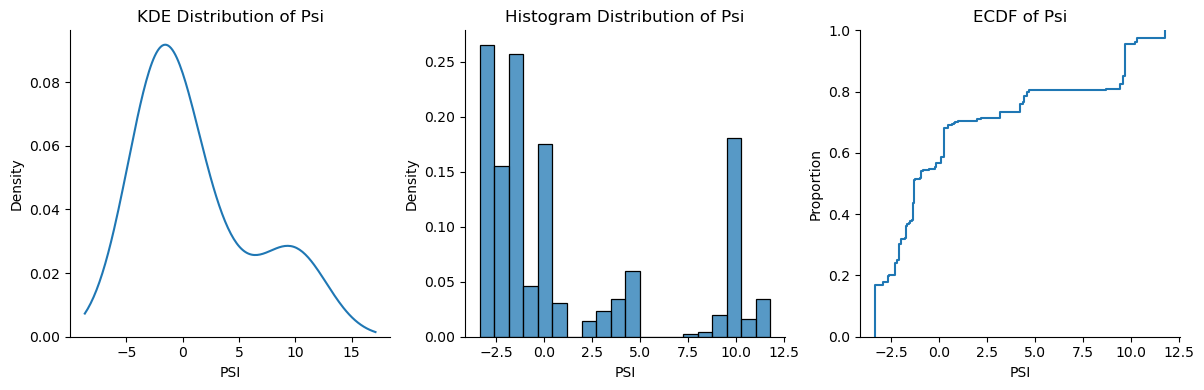

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# KDE plot
sns.kdeplot(data=ind_3_tele, x="PSI", weights="JOB_CREATION_BIRTHS", ax=axes[0])
sns.despine(ax=axes[0])
axes[0].set_title("KDE Distribution of Psi")

# Histogram plot
sns.histplot(data=ind_3_tele, x="PSI", weights="JOB_CREATION_BIRTHS", bins=20, stat="density", ax=axes[1])
sns.despine(ax=axes[1])
axes[1].set_title("Histogram Distribution of Psi")

# ECDF plot
sns.ecdfplot(data=ind_3_tele, x="PSI", weights="JOB_CREATION_BIRTHS", ax=axes[2])
sns.despine(ax=axes[2])
axes[2].set_title("ECDF of Psi")

plt.tight_layout()
plt.show()

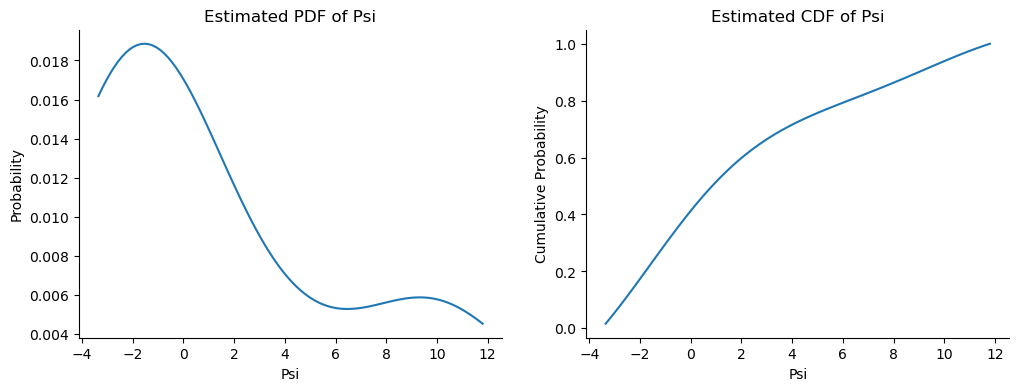

In [37]:
from scipy.stats import gaussian_kde

psi_values = ind_3_tele['PSI'].values
weights = ind_3_tele["JOB_CREATION_BIRTHS"].values

kde = gaussian_kde(psi_values, weights=weights)
num_grid_points = 100  # Adjust based on your model's needs
grid = np.linspace(psi_values.min(), psi_values.max(), num_grid_points)
pdf_values = kde.evaluate(grid)
probabilities = pdf_values / pdf_values.sum()  # Ensure sum to 1
psi_distribution = pd.DataFrame({
    'grid_point': grid,
    'pdf': probabilities
})
psi_distribution["probability"] = psi_distribution["pdf"] / psi_distribution["pdf"].sum()
psi_distribution["cdf"] = psi_distribution["probability"].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(ax = ax[0], data=psi_distribution, x='grid_point', y='probability')
ax[0].set_xlabel('Psi')
ax[0].set_ylabel('Probability')
ax[0].set_title('Estimated PDF of Psi')

sns.lineplot(ax = ax[1], data=psi_distribution, x='grid_point', y='cdf')
ax[1].set_xlabel('Psi')
ax[1].set_ylabel('Cumulative Probability')
ax[1].set_title('Estimated CDF of Psi')

sns.despine()
plt.show()

In [38]:
dd = wfh_rates[["NAICS", "WFH_INDEX"]].merge(ind_3_tele, on = "NAICS")

In [39]:
psi_0_ind = 88
psi, cdf_psi = psi_distribution.iloc[psi_0_ind][["grid_point", "cdf"]]
1 - (dd[dd.PSI <= psi].WFH_INDEX.sum() / dd.WFH_INDEX.sum()) * cdf_psi

0.10175523480508808

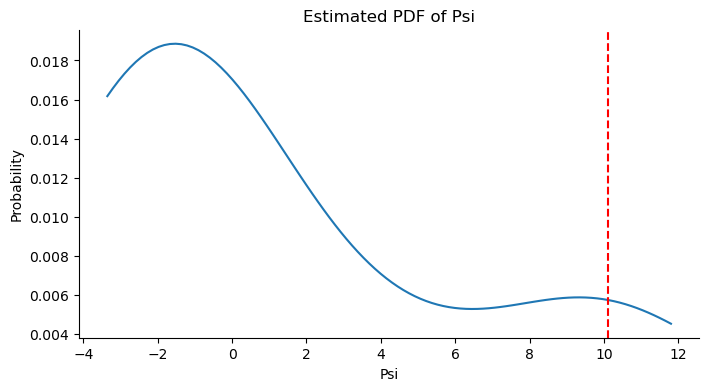

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(ax = ax, data=psi_distribution, x='grid_point', y='probability')
sns.despine()
vline = psi_distribution.iloc[psi_0_ind]['grid_point']
ax.axvline(x=vline, color='red', linestyle='--')
ax.set_xlabel('Psi')
ax.set_ylabel('Probability')
ax.set_title('Estimated PDF of Psi');

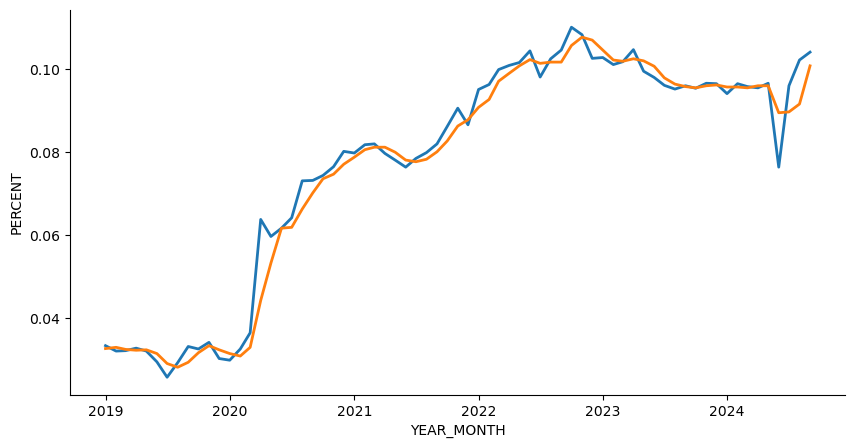

In [41]:
job_posting_data = pd.read_csv("../../../data/processed/wfh_map/country_by_month.csv",
                                # usecols = ["NAICS", "N", "PERCENT"],
                                dtype = {"OCC_CODE": str})
job_posting_data["PERCENT"] = job_posting_data["PERCENT"] / 100
job_posting_data["PERCENT_3MA"] = job_posting_data["PERCENT_3MA"] / 100
job_posting_data["YEAR_MONTH"] = pd.to_datetime(job_posting_data["YEAR_MONTH"])

plt.figure(figsize=(10, 5))
sns.lineplot(data=job_posting_data, x="YEAR_MONTH", y="PERCENT", linewidth=2)
sns.lineplot(data=job_posting_data, x="YEAR_MONTH", y="PERCENT_3MA", linewidth=2)
sns.despine()
plt.show()


In [42]:
abilities = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/onet_data/processed/measure/ABILITIES.csv")
skills = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/onet_data/processed/measure/SKILLS.csv")
occ_data = pd.read_csv("/project/high_tech_ind/WFH/WFH/data/onet_data/processed/reference/OCCUPATION_DATA.csv")

skills = skills.pivot(
    index=["ONET_SOC_CODE", "ELEMENT_ID", "ELEMENT_NAME"],
    columns="SCALE_ID",
    values="DATA_VALUE"
).reset_index().fillna(0)

abilities = abilities.pivot(
    index=["ONET_SOC_CODE", "ELEMENT_ID", "ELEMENT_NAME"],
    columns="SCALE_ID",
    values="DATA_VALUE"
).reset_index().fillna(0)

# Normalize abilities to the 0 1 scale
abilities["IM"] = (abilities["IM"] - abilities["IM"].min()) / (abilities["IM"].max() - abilities["IM"].min())
abilities["LV"] = (abilities["LV"] - abilities["LV"].min()) / (abilities["LV"].max() - abilities["LV"].min())
abilities['SKILL_INDEX'] = abilities['IM'] * abilities['LV']



# Normalize IM and LV to the 0 1 scale
skills["IM"] = (skills["IM"] - skills["IM"].min()) / (skills["IM"].max() - skills["IM"].min())
skills["LV"] = (skills["LV"] - skills["LV"].min()) / (skills["LV"].max() - skills["LV"].min())
skills['SKILL_INDEX'] = skills['IM'] * skills['LV']

all_data = pd.concat([skills, abilities], axis=0)

all_data = all_data.groupby(["ONET_SOC_CODE"]).agg({"SKILL_INDEX": "mean"}).reset_index()
# # Add the occupation titles
all_data = all_data.merge(occ_data[["ONET_SOC_CODE", "OCCUPATION_TITLE"]], on="ONET_SOC_CODE")
all_data = all_data.sort_values("SKILL_INDEX", ascending=False)
# Normalize the skill index to the 0 1 scale
all_data["SKILL_INDEX"] = (all_data["SKILL_INDEX"] - all_data["SKILL_INDEX"].min()) / (all_data["SKILL_INDEX"].max() - all_data["SKILL_INDEX"].min())
all_data = all_data.merge(onet_soc_xwalk[["ONET_SOC_CODE", "OCC_CODE"]], on="ONET_SOC_CODE")
all_data

,ONET_SOC_CODE,SKILL_INDEX,OCCUPATION_TITLE,OCC_CODE
0,53-2011.00,1.000000,"Airline Pilots, Copilots, and Flight Engineers",53-2011
1,17-2199.08,0.845322,Robotics Engineers,17-2199
2,19-2012.00,0.833057,Physicists,19-2012
3,29-1021.00,0.828603,"Dentists, General",29-1021
4,17-2112.03,0.822251,Manufacturing Engineers,17-2112
...,...,...,...,...
874,39-5093.00,0.084179,Shampooers,39-5093
875,35-2021.00,0.083464,Food Preparation Workers,35-2021
876,39-3093.00,0.048349,"Locker Room, Coatroom, and Dressing Room Atten...",39-3093
877,45-2041.00,0.027911,"Graders and Sorters, Agricultural Products",45-2041


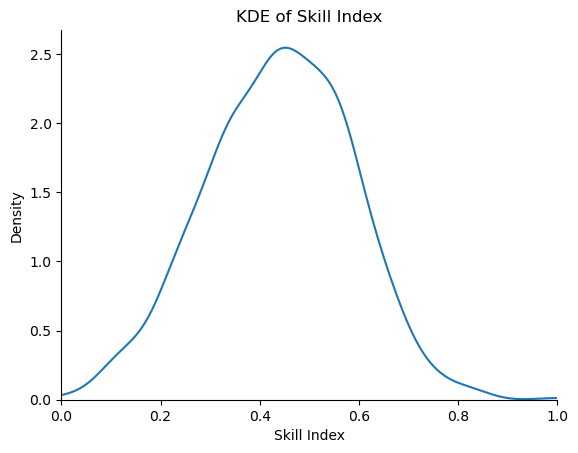

In [43]:
# Plot KDE of skill_index
sns.kdeplot(data=all_data, x="SKILL_INDEX")
plt.title("KDE of Skill Index")
plt.xlabel("Skill Index")
plt.ylabel("Density")
# Limit to 0 1 range
plt.xlim(0, 1)
sns.despine()
plt.show()

In [46]:
all_data_soc = all_data.groupby("OCC_CODE").agg({"SKILL_INDEX": "mean"}).reset_index()
# wfh_share_estimation_occ = wfh_share_estimation.merge(onet_soc_xwalk[["ONET_SOC_CODE", "OCC_CODE"]], on="ONET_SOC_CODE", how="left")
# wfh_share_estimation_occ = wfh_share_estimation_occ.groupby("OCC_CODE")["ESTIMATE_WFH_ABLE"].mean().reset_index()
wfh_share_estimation_occ = wfh_share_estimation_occ.merge(all_data_soc, on="OCC_CODE", how="inner").set_index("OCC_CODE")

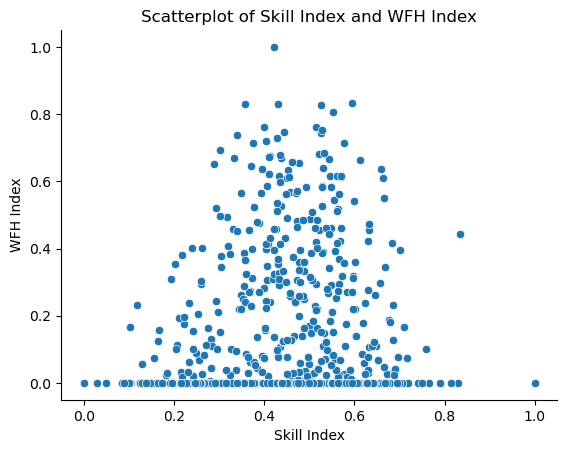

In [47]:
sns.scatterplot(data=wfh_share_estimation_occ, x="SKILL_INDEX", y="ESTIMATE_WFH_ABLE")
plt.title("Scatterplot of Skill Index and WFH Index")
plt.xlabel("Skill Index")
plt.ylabel("WFH Index")
sns.despine()
plt.show()

In [48]:
bls_ind_3d_wide = bls_ind_3d[["NAICS", "NAICS_TITLE", "OCC_CODE", "TOT_EMP"]].pivot(
    index=["NAICS", "NAICS_TITLE"],
    columns="OCC_CODE",
    values="TOT_EMP"
).fillna(0)
# Normalize the occupation composition
bls_ind_3d_wide = bls_ind_3d_wide.div(bls_ind_3d_wide.sum(axis=1), axis=0)

In [49]:
# Create a dictionary mapping each occupation to its remote work estimate
wfh_map = wfh_share_estimation_occ[['ESTIMATE_WFH_ABLE', 'SKILL_INDEX']].to_dict()


# Determine which occupation columns in the wide DataFrame are in the mapping
common_occ = list( set(bls_ind_3d_wide.columns).intersection(wfh_map['ESTIMATE_WFH_ABLE'].keys()) )

# # Create a copy and multiply each matching column by its corresponding weight
bls_ind_3d_wide_weighted_remote = bls_ind_3d_wide.copy()
bls_ind_3d_wide_weighted_skill = bls_ind_3d_wide.copy()
for occ in bls_ind_3d_wide_weighted.columns:
    if occ in common_occ:
        # Weight the occupation column by the remote work estimate and skill index
        bls_ind_3d_wide_weighted_remote[occ] = bls_ind_3d_wide_weighted_remote[occ] * wfh_map['ESTIMATE_WFH_ABLE'][occ]
        bls_ind_3d_wide_weighted_skill[occ] = bls_ind_3d_wide_weighted_skill[occ] * wfh_map['SKILL_INDEX'][occ]
    else:
        # Set the column to zero if it is not in the mapping
        bls_ind_3d_wide_weighted_remote[occ] = 0
        bls_ind_3d_wide_weighted_skill[occ] = 0

# Create the industry-level remote work and skill index measures
ind_3_tele = bls_ind_3d_wide_weighted_remote.sum(axis=1).to_frame().reset_index().rename(columns={0: "TELE"})
ind_3_skill = bls_ind_3d_wide_weighted_skill.sum(axis=1).to_frame().reset_index().rename(columns={0: "SKILL"})

ind_3 = ind_3_tele.merge(ind_3_skill, on=["NAICS",'NAICS_TITLE'], how="inner")
ind_3

,NAICS,NAICS_TITLE,TELE,SKILL
0,113,Forestry and Logging,0.024382,0.406415
1,115,Support Activities for Agriculture and Forestry,0.023704,0.372206
2,211,Oil and Gas Extraction,0.188411,0.448634
3,212,Mining (except Oil and Gas),0.044960,0.454341
4,213,Support Activities for Mining,0.071500,0.445086
...,...,...,...,...
80,722,Food Services and Drinking Places,0.009778,0.232739
81,811,Repair and Maintenance,0.061820,0.389858
82,812,Personal and Laundry Services,0.037584,0.250261
83,813,"Religious, Grantmaking, Civic, Professional, a...",0.219323,0.351202


In [50]:
data = productivity_3d[
    ["Sector", "Year", "NAICS", "sectoral_output_millions", "hours_worked_millions", "sectoral_output_price_deflator_index", "employment_thousands"]
    ].rename(columns=lambda x : x.upper()).merge(
        ind_3, on="NAICS", how="left"
    ).merge(
        wfh_rates_3d[["YEAR",	"NAICS", "WFH_INDEX"]], on=["YEAR", "NAICS"], how="inner"
    ).rename(columns={"WFH_INDEX": "ALPHA"}).copy()
data["OUTPUT"] = ( data["SECTORAL_OUTPUT_MILLIONS"] / data["HOURS_WORKED_MILLIONS"] ) / data["SECTORAL_OUTPUT_PRICE_DEFLATOR_INDEX"] 
data["LOG_SKILL"] = np.log(data["SKILL"])

In [51]:
# Drop missing values
data = data.dropna(subset=["TELE", "ALPHA", "OUTPUT", "SKILL"])
data["YEAR"] = data["YEAR"].astype(int)

# Define regression formulas
formula1 = "OUTPUT ~ SKILL  + ALPHA:SKILL + TELE:ALPHA:SKILL + SKILL:LOG_SKILL"
formula1_no_intercept = "OUTPUT ~ SKILL   + ALPHA:SKILL + TELE:ALPHA:SKILL + SKILL:LOG_SKILL - 1"
formula2 = "OUTPUT ~ SKILL  + ALPHA:SKILL + TELE:ALPHA:SKILL + SKILL:LOG_SKILL + C(YEAR)"
formula2_no_intercept = "OUTPUT ~ SKILL   + ALPHA:SKILL + TELE:ALPHA:SKILL + SKILL:LOG_SKILL - 1 + C(YEAR)"
formula3 = "OUTPUT ~ SKILL  + ALPHA:SKILL + TELE:ALPHA:SKILL + SKILL:LOG_SKILL + C(SECTOR)"
formula3_no_intercept = "OUTPUT ~ SKILL   + ALPHA:SKILL + TELE:ALPHA:SKILL + TELE:ALPHA + SKILL:LOG_SKILL - 1 + C(SECTOR)"


# Fit the model (with and without intercept)
model1 = smf.ols(formula=formula1, data=data).fit(cov_type='HC3')
model1_no_intercept = smf.ols(formula=formula1_no_intercept, data=data).fit(cov_type='HC3')
# Year fixed effects
model2 = smf.ols(formula=formula2, data=data).fit(cov_type='HC3')
model2_no_intercept = smf.ols(formula=formula2_no_intercept, data=data).fit(cov_type='HC3')
# Sector fixed effects
model3 = smf.ols(formula=formula3, data=data).fit(cov_type='HC3')
model3_no_intercept = smf.ols(formula=formula3_no_intercept, data=data).fit(cov_type='HC3')


table = summary_col([model1, model1_no_intercept, model2, model2_no_intercept, model3, model3_no_intercept],
                    stars=True,
                    float_format="%.3f",
                    model_names=["No FE", "No FE (No Intercept)", "Year FE", "Year FE (No Intercept)", "Sector FE", "Sector FE (No Intercept)"], 
                    info_dict={'N': lambda x: f"{int(x.nobs)}", 'R-squared': lambda x: f"{x.rsquared:.3f}"}
)

display(table)

,No FE,No FE (No Intercept),Year FE,Year FE (No Intercept),Sector FE,Sector FE (No Intercept)
Intercept,16.739***,,16.291***,,43.272***,
,(6.151),,(6.245),,(11.574),
SKILL,25.708***,23.910***,26.279***,26.279***,37.024***,31.329***
,(4.345),(3.704),(4.533),(4.533),(7.439),(7.335)
ALPHA:SKILL,-37.564**,-34.714**,-53.873**,-53.873**,-29.745,-49.126***
,(17.131),(16.605),(25.035),(25.035),(18.336),(17.647)
TELE:ALPHA:SKILL,315.199***,286.139***,356.831***,356.831***,176.199**,2094.673***
,(73.476),(69.150),(96.784),(96.784),(79.352),(547.804)
SKILL:LOG_SKILL,64.152***,15.974***,63.632***,63.632***,149.791***,141.109***
,(20.580),(3.107),(20.891),(20.891),(38.729),(37.378)


In [56]:
print(summary_col([model1],
                  stars=True,
                  float_format="%.3f",
                  model_names=["No FE", "No FE (No Intercept)", "Year FE", "Year FE (No Intercept)", "Sector FE", "Sector FE (No Intercept)"],
                  info_dict={'N': lambda x: f"{int(x.nobs)}", '$R^2$': lambda x: f"{x.rsquared:.3f}"}
                 ).as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
                 & No FE       \\
\hline
Intercept        & 16.739***   \\
                 & (6.151)     \\
SKILL            & 25.708***   \\
                 & (4.345)     \\
ALPHA:SKILL      & -37.564**   \\
                 & (17.131)    \\
TELE:ALPHA:SKILL & 315.199***  \\
                 & (73.476)    \\
SKILL:LOG\_SKILL & 64.152***   \\
                 & (20.580)    \\
R-squared        & 0.263       \\
R-squared Adj.   & 0.256       \\
N                & 418         \\
\$R^2\$          & 0.263       \\
\hline
\end{tabular}
\end{center}
\end{table}
\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


In [52]:
# define model to use
model = model1
# Obtain the model coefficients
beta_0 = model.params["SKILL"]
beta_1 = model.params["ALPHA:SKILL"]
beta_2 = model.params["TELE:ALPHA:SKILL"]
beta_3 = model.params["SKILL:LOG_SKILL"]

# Construct the "other" coefficient
A = beta_0
delta_0 = (beta_1 + 1) / A
delta_1 = beta_2 / A
delta_2 = beta_3 / A
print(f"A: {A:.3f}")
print(f"delta_0: {delta_0:.3f}")
print(f"delta_1: {delta_1:.3f}")
print(f"delta_2: {delta_2:.3f}")

A: 25.708
delta_0: -1.422
delta_1: 12.261
delta_2: 2.495


In [ ]:
# Construct psi = delta_0 + delta_1 * TELE + delta_2 * LOG_SKILL
ind_3["PSI"] = delta_0 + delta_1 * ind_3["TELE"] + delta_2 * np.log(ind_3["SKILL"])
ind_3 = ind_3.merge(bds_3d.loc[bds_3d.year == 2022, ["job_creation_births", "NAICS"]], on = "NAICS")
ind_3["JOB_CREATION_BIRTHS"] = pd.to_numeric(ind_3["job_creation_births"], errors='coerce')
ind_3.drop(columns = ["job_creation_births"], inplace = True)

In [ ]:
ind_3.PSI.

,TELE,SKILL,PSI,JOB_CREATION_BIRTHS
count,74.000000,74.000000,74.000000,74.000000
mean,0.129657,0.345992,-2.726392,73518.000000
std,0.110989,0.068608,1.575415,142720.100777
min,0.009778,0.123319,-6.666113,20.000000
25%,0.052292,0.309149,-3.563142,6761.750000
50%,0.080591,0.347927,-3.078976,26139.500000
75%,0.176473,0.379041,-1.793054,84849.750000
max,0.410527,0.497787,0.886390,918022.000000


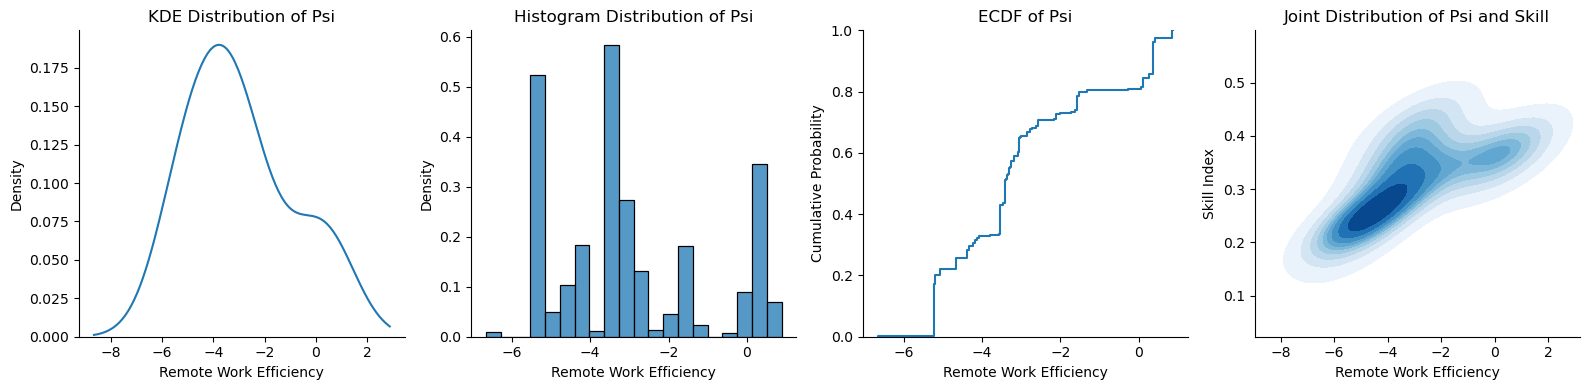

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# KDE plot
sns.kdeplot(data=ind_3, x="PSI", weights="JOB_CREATION_BIRTHS", ax=axes[0])
axes[0].set_title("KDE Distribution of Psi")
axes[0].set_xlabel("Remote Work Efficiency")
axes[0].set_ylabel("Density")

# Histogram plot
sns.histplot(data=ind_3, x="PSI", weights="JOB_CREATION_BIRTHS", bins=20, stat="density", ax=axes[1])
axes[1].set_title("Histogram Distribution of Psi")
axes[1].set_xlabel("Remote Work Efficiency")

# ECDF plot
sns.ecdfplot(data=ind_3, x="PSI", weights="JOB_CREATION_BIRTHS", ax=axes[2])
axes[2].set_ylabel("Cumulative Probability")
axes[2].set_title("ECDF of Psi")
axes[2].set_xlabel("Remote Work Efficiency")

# Joint Distribution of Psi and Skill
sns.kdeplot(data=ind_3, y="SKILL", x="PSI", weights=ind_3["JOB_CREATION_BIRTHS"], cmap="Blues", fill=True, ax=axes[3])
axes[3].set_xlabel("Remote Work Efficiency")
axes[3].set_ylabel("Skill Index")
axes[3].set_title("Joint Distribution of Psi and Skill")

for ax in axes:
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

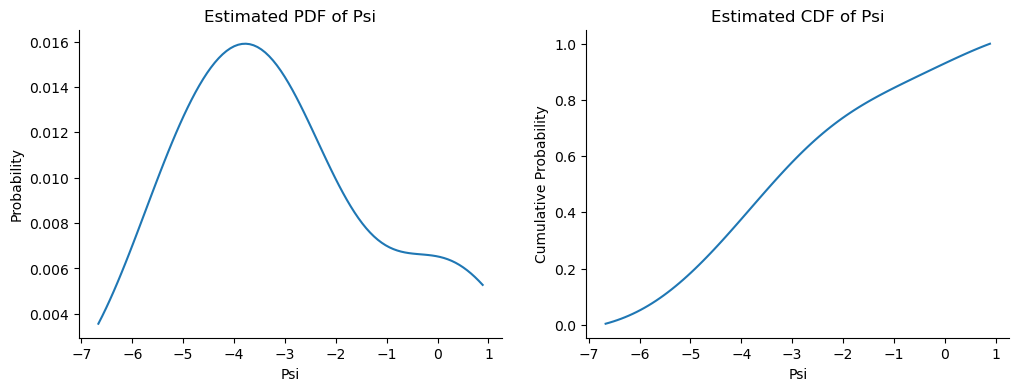

In [ ]:
from scipy.stats import gaussian_kde

psi_values = ind_3['PSI'].values
weights = ind_3["JOB_CREATION_BIRTHS"].values

kde = gaussian_kde(psi_values, weights=weights)
num_grid_points = 100  # Adjust based on your model's needs
grid = np.linspace(psi_values.min(), psi_values.max(), num_grid_points)
pdf_values = kde.evaluate(grid)
probabilities = pdf_values / pdf_values.sum()  # Ensure sum to 1
psi_distribution = pd.DataFrame({
    'grid_point': grid,
    'pdf': probabilities
})
psi_distribution["probability"] = psi_distribution["pdf"] / psi_distribution["pdf"].sum()
psi_distribution["cdf"] = psi_distribution["probability"].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(ax = ax[0], data=psi_distribution, x='grid_point', y='probability')
ax[0].set_xlabel('Psi')
ax[0].set_ylabel('Probability')
ax[0].set_title('Estimated PDF of Psi')

sns.lineplot(ax = ax[1], data=psi_distribution, x='grid_point', y='cdf')
ax[1].set_xlabel('Psi')
ax[1].set_ylabel('Cumulative Probability')
ax[1].set_title('Estimated CDF of Psi')

sns.despine()
plt.show()